In [3]:
import pandas as pd
import numpy as np 
import sys
import time 

import geopandas as gpd
import shapely
import fiona
import folium

import seaborn as sns
import matplotlib.pyplot as plt

# sys.path.insert(0,'Repos/newcastle/air-quality/src/')
sys.path.insert(0,'../src')
from v0 import *

## Dataset

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_allsensors_8days/'
metadata, osmf, sensors = load_data(SHAPE_FOLDER, DATA_FOLDER)

variables =  {
        'sensors':['NO2','Temperature','Humidity','O3','CO','PM10'],
        'exogenous':['primary','trunk','motorway','signals','day','dow','hour'] #'street' = 'primary','trunk','motorway','traffic_signals'
}
sensors, metadata = resampling_sensors(sensors, metadata, variables, 'H')

## 1. Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [7]:
t0 = time.time()

variables = {
    'sensors':['CO', 'Humidity', 'NO2', 'O3', 'PM10', 'Temperature'],
    'exogenous':['primary','trunk','motorway','traffic_signals','hour']
}

zx, zi = ingestion(sensors, metadata, osmf, variables, k=5, target='NO2', method='randomized')
print(zx.shape,zi.shape)
print(time.time()-t0)
zx.head()

(751, 65) (751, 1)
94.11212801933289


CO          CO          CO  \
Sensor Name    Timestamp                                                 
aq_mesh1756150 2018-07-09 00:00:00  227.033756  159.018608  234.701103   
               2018-07-09 01:00:00  264.299415  241.889935  225.305554   
               2018-07-09 02:00:00  226.509429  183.625153  240.188610   
               2018-07-09 03:00:00  275.734486  218.372339  245.114108   
               2018-07-09 04:00:00  207.407473  166.346537  252.964715   

                                            CO          CO      d_CO  \
Sensor Name    Timestamp                                               
aq_mesh1756150 2018-07-09 00:00:00  410.280895  553.740759  0.002771   
               2018-07-09 01:00:00  301.213972  328.596894  0.002771   
               2018-07-09 02:00:00  305.923421  344.552630  0.002771   
               2018-07-09 03:00:00  309.918739  334.788349  0.002771   
               2018-07-09 04:00:00  298.708214  313.403126  0.002771   

                                        d_CO      d_CO      d_CO      d_CO  \
Sensor Name    Timestamp                                                     
aq_mesh1756150 2018-07-09 00:00:00  0.004590  0.003261  0.004958  0.002386   
               2018-07-09 01:00:00  0.004958  0.003261  0.005017  0.002386   
               2018-07-09 02:00:00  0.004590  0.003261  0.004958  0.002386   
               2018-07-09 03:00:00  0.004958  0.003261  0.005017  0.002386   
               2018-07-09 04:00:00  0.004590  0.003261  0.004958  0.002386   

                                         ...         d_Temperature  \
Sensor Name    Timestamp                 ...                         
aq_mesh1756150 2018-07-09 00:00:00       ...              0.002386   
               2018-07-09 01:00:00       ...              0.002386   
               2018-07-09 02:00:00       ...              0.002386   
               2018-07-09 03:00:00       ...              0.002386   
               2018-07-09 04:00:00       ...              0.002386   

                                    d_Temperature  d_Temperature  \
Sensor Name    Timestamp                                           
aq_mesh1756150 2018-07-09 00:00:00       0.003558       0.002772   
               2018-07-09 01:00:00       0.003726       0.002772   
               2018-07-09 02:00:00       0.003726       0.002772   
               2018-07-09 03:00:00       0.003726       0.002772   
               2018-07-09 04:00:00       0.003726       0.002772   

                                    d_Temperature  d_Temperature  hour  \
Sensor Name    Timestamp                                                 
aq_mesh1756150 2018-07-09 00:00:00       0.003726       0.001956     0   
               2018-07-09 01:00:00       0.003985       0.001956     1   
               2018-07-09 02:00:00       0.003987       0.001956     2   
               2018-07-09 03:00:00       0.003985       0.001956     3   
               2018-07-09 04:00:00       0.003987       0.001956     4   

                                       primary       trunk    motorway  \
Sensor Name    Timestamp                                                 
aq_mesh1756150 2018-07-09 00:00:00  249.622717  116.555116  114.232136   
               2018-07-09 01:00:00  249.622717  116.555116  114.232136   
               2018-07-09 02:00:00  249.622717  116.555116  114.232136   
               2018-07-09 03:00:00  249.622717  116.555116  114.232136   
               2018-07-09 04:00:00  249.622717  116.555116  114.232136   

                                    traffic_signals  
Sensor Name    Timestamp                             
aq_mesh1756150 2018-07-09 00:00:00       372.682622  
               2018-07-09 01:00:00       372.682622  
               2018-07-09 02:00:00       372.682622  
               2018-07-09 03:00:00       372.682622  
               2018-07-09 04:00:00       372.682622  

[5 rows x 65 columns]

In [155]:
# t0 = time.time()
# zx = ingestion2(sensors, metadata, variables['sensors'], osmf)
# print(time.time()-t0)

175.84375262260437


### 1.a. Inverse Distance Weighting

In [ ]:
def iwd_features(zx, sensor_variables):
    ziwd = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        ziwd['iwd_{}'.format(var)] = (((zx['d_{}'.format(var)].values*zx[var].values).sum(axis=1))/zx['d_{}'.format(var)].values.sum(axis=1))
    return ziwd
ziwd = iwd_features(zx, variables['sensors'])
ziwd = ziwd.join(zx[variables['exogenous']])
ziwd.head()

### 1.b. Spatial Averaging

In [40]:
def spavg_features(zx, sensor_variables):
    zavg = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        zavg['spavg_{}'.format(var)] = zx[var].values.sum(axis=1)/zx[var].shape[1]
    return zavg   
zavg = spavg_features(zx, variables['sensors'])
zavg = zavg.join(zx[variables['exogenous']])

### 1.b. Nearest Neighbor

In [63]:
def nn_features(zx, sensor_variables):
    znn = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        znn['nn_{}'.format(var)] = zx[['d_{}'.format(var),var]].apply(lambda x: x[var].values[x['d_{}'.format(var)].values.argmin()], axis=1)
    return znn
znn = nn_features(zx, variables['sensors'])
znn = znn.join(zx[variables['exogenous']])

### Feature correlation visualization

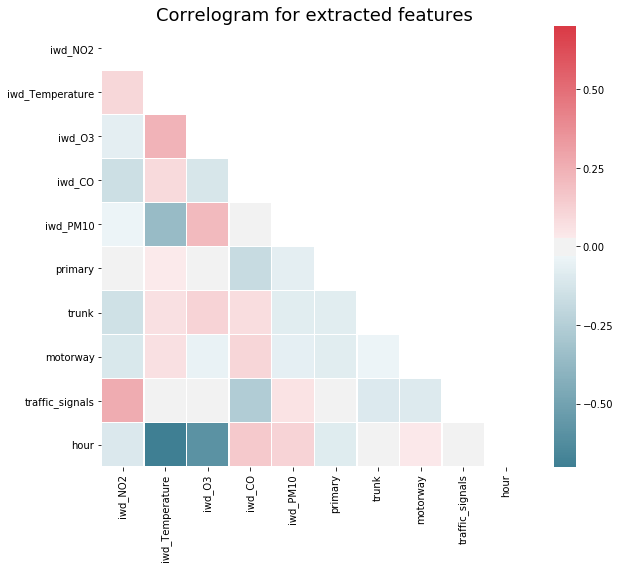

In [14]:
def corrplot(zx):
    corr = zx.convert_objects(convert_numeric=True).corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(9,8));
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, vmin=-.7,linewidths=.5, ax=axes)
    plt.title('Correlogram for extracted features', fontsize=18)
    plt.tight_layout()
#     plt.savefig(DATA_FOLDER+'plots/correlogram_general.svg', format='svg', dpi=600)
corrplot(ziwd)